# Maxcut by QAOA and Quantum annealer

# 1. Graph definition

In [1705]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
import numpy as np

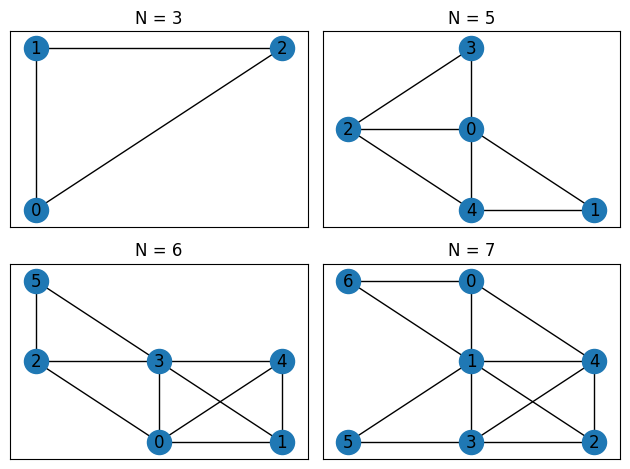

In [1706]:
edgelists = [[(0, 1), (0, 2), (1, 2)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5)],
             [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (3, 4), (3, 5)]]


coordinate_list = [[(0, 0), (0, 1), (1, 1)],
                   [(1, 1), (2, 0), (0, 1), (1, 2), (1, 0)],
                   [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2)],
                   [(1, 2), (1, 1), (2, 0), (1, 0), (2, 1), (0, 0), (0, 2)]]


G_set = [nx.from_edgelist(edgelist) for edgelist in edgelists]
matrices_adj = [np.array(nx.adjacency_matrix(G).todense().tolist()) for G in G_set]

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    pos = {n: pos for n, pos in enumerate(coordinate_list[i])}  
    nx.draw_networkx(G_set[i], pos, ax=ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))

#fig.suptitle("Graphs of Interest")
plt.tight_layout()
plt.show()

In [1707]:
matrices_adj[1]

array([[0, 1, 1, 1, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0]])

# 2. Classical calculation

In [1708]:
from itertools import combinations

def get_max_cut(G):
    """
    This function computes the max cut of a given graph.

    Input: Graph G

    Output: max_cut of the graph and associated partition
    """
    def two_partitions(lst):
        result = set()
        
        # Generate all possible combinations for the first subset
        for i in range(1, len(lst)):
            for part1 in combinations(lst, i):
                part1 = set(part1)
                part2 = set(lst) - part1  # The other subset is what remains
                # Add the partition to the set to avoid duplicates
                parti = frozenset([frozenset(part1), frozenset(part2)])
                result.add(parti)
        
        # Convert partitions to lists 
        return [list(map(list, parti)) for parti in result]
    
    partitions = two_partitions(range(len(G.nodes())))
    new_partitions = []

    for part in partitions:
        cut = 0
        for u in part[0]:
            for v in part[1]:
                if G.has_edge(u, v):
                    cut += 1

        # Add the partition with the cut count at the beginning
        new_partitions.append([cut] + part)

    max_cut = max(partition[0] for partition in new_partitions)
    max_cut_partitions = [partition for partition in new_partitions if partition[0] == max_cut]

    return max_cut, max_cut_partitions


In [1709]:
for graph in G_set:
    print(get_max_cut(graph))

(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])


# 3. QAOA

L'algorithme QAOA et constituer de deux principale partie.
* L'Opérateur de Mixage.
$$ 
U_m(\beta) = e^{-i\beta H_{m}}
$$
Où $H_m$ est l'opérateur de mixage.
$U_m$ permet de créer une superposition d'état pour la recherche de la solution au probléme. tout en permttant d'agir sur l'amplitude de ces états.

* L'opérateur de coût.
$$
U_c(\alpha) = e^{-i\alpha H_c}
$$

Où $H_c$ est l'hamiltonien du probléme.
le rôle de $U_c$ est de créer des intérférences dans l'ensemble des états afin d'explorer des superposition d'état comme solution.

Ces étapes s'intégre alors dans une bourcle d'optimisation comme ceci:

* On commence par initialiser les qubits dans l'état fondamentle de $H_m$.
$$
 \ket{\Psi_{initial}}
$$ 

* On applique ensuit l'opérateur de mixage.
$$
U_{m}(\beta)\ket{\Psi_{initial}}
$$

* On applique l'opérateur de Coût
$$
\ket{\Psi_{\alpha , \beta}} = U_{c}(\alpha)U_{m}(\beta)\ket{\Psi_{initial}}
$$

* En suite on élévalue le coût (l'énrgie) de l'état $\ket{\Psi_{\alpha , \beta}}$. en calculant
$$
C = \bra{\Psi_{\alpha , \beta}}H_{c}\ket{\Psi_{\alpha , \beta}}
$$

On rzitére le proccessus en ajustent les paramétre $\alpah$ et $\beta$ de façon à minimiser le coût C. l'état correspondant à la valeur minimale de C est la solution.

Pour améliorer l'approximation de l'algorihme , au lieux d'un seul couple de paramétre $(\alpha , \beta)$ , on un vecteur de paramétre 






# 3. QAOA

L'algorithme QAOA (Quantum Approximate Optimization Algorithm) repose sur deux principales opérations :

### 1. L'Opérateur de Mixage
L'opérateur de mixage permet de créer une superposition d'états dans l'espace de Hilbert. Il est défini par l'exponentielle de l'opérateur $H_m$, appelé l'Hamiltonien de mixage :
$$ 
U_m(\beta) = e^{-i\beta H_{m}}
$$
 Cet opérateur permet de transformer l'état quantique en une superposition d'états des états possible. le paramétre $\beta$ contrôle les probabilités de ce ces états

### 2. L'Opérateur de Coût
L'opérateur de coût est definit par l'hamiltonien du problème que l'on souhaite optimiser :
$$
U_c(\alpha) = e^{-i\alpha H_c}
$$
Ici, $\alpha$ est un autre paramètre de contrôle. L'opérateur $U_c$ crée des intérférences dans l'ensemble des états afin d'explorer des superpositions d'état comme solution.

### 3. Processus de l'algorithme

L'algorithme QAOA fonctionne selon les étapes suivantes :

1. **Initialisation** : On initialise les qubits dans l'état fondamental du Hamiltonien $H_m$. 
   $$ 
   \ket{\Psi_{\text{initial}}} = \frac{1}{\sqrt{N}} \sum_{x} \ket{x} 
   $$ 
   où \(N\) est le nombre total d'états possibles.

2. **Application de l'Opérateur de Mixage** : On applique l'opérateur de mixage pour générer une superposition d'états, en modifiant les amplitudes des états quantiques.
   $$ 
   \ket{\Psi_1} = U_m(\beta) \ket{\Psi_{\text{initial}}}
   $$

3. **Application de l'Opérateur de Coût** : Ensuite, l'opérateur de coût . 
   $$ 
   \ket{\Psi_{\alpha, \beta}} = U_c(\alpha) U_m(\beta) \ket{\Psi_{\text{initial}}}
   $$

4. **Évaluation du Coût** : On calcule l'énergie associée à l'état $\ket{\Psi_{\alpha, \beta}}$ en utilisant l'hamiltonien du problème $H_c$. Cela donne une mesure de la qualité de la solution actuelle :
   $$ 
   C = \bra{\Psi_{\alpha, \beta}} H_c \ket{\Psi_{\alpha, \beta}}
   $$

5. **Optimisation des Paramètres** : Les paramètres $\alpha$ et $\beta$ sont ajustés afin de minimiser le coût $C$. Cette optimisation est effectuée par un algorithme classique, par exemple, en utilisant des méthodes de gradient ou d'autres techniques d'optimisation numérique. L'objectif est de minimiser la valeur de $C$, ce qui correspond à trouver la solution optimale du problème.


Afin d'améliorer l'approximation de la solution, l'algorithme QAOA peut être étendu pour utiliser plusieurs paires de paramètres $(\alpha_k, \beta_k)$. Cela permet d'augmenter la profondeur de l'algorithme, en appliquant plusieurs cycles d'optimisation alternant les opérateurs de mixage et de coût.

In [1710]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from scipy.optimize import minimize

## 3.1 Initialization

In [1711]:
def U_init(nombre_de_qubit):
    qc = QuantumCircuit(nombre_de_qubit)
    qc.x(range(nombre_de_qubit))
    qc.h(range(nombre_de_qubit))
    
    return qc

## 3.2 Build $U_{m}$

In [1712]:
def U_m(n, beta):
    """
        input: n: nombre de qubit
               t: temps d'évolution
        ouput: QuantumCircuit
    """
    # Définir les matrices de Pauli et l'identité
    I = SparsePauliOp("I")
    X = SparsePauliOp("X")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for i in range(n):
        A = [I] * n
        A[i] = X
        operator = A[0]
        
        for matrix in A[1:]:
            operator = operator ^ matrix
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator

    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=beta)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit

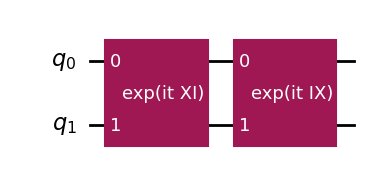

In [1713]:
# Exemple d'utilisation de la fonction
n = 2
beta = 0.2
circuit = U_m(n, beta)
circuit.decompose().draw("mpl")

## 3.3 Build $U_c$

In [1714]:
def U_c(n, hamiltonian, alpha):
    # Définir les matrices de Pauli et l'identité
    """
    input: 
        n: nombre de qubit
        hamiltonien: branches du graphes
        temps d'évolution
    ouput: QuantumCircuit
    """
    
    def interaction(hamiltonian):
        non_nuls = []
        for i, ligne in enumerate(hamiltonian):
            for j, element in enumerate(ligne):
                if element != 0:
                    non_nuls.append((i, j))
        return non_nuls

    list_of_connection = interaction(hamiltonian)
    I = SparsePauliOp("I")
    Z = SparsePauliOp("Z")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for (i, j) in list_of_connection:
        # Créer un vecteur de matrices I
        A = [I] * n
        # Remplacer les ième et jième éléments par Z
        A[i] = Z
        A[j] = Z
        # Initialiser l'opérateur avec la première matrice du vecteur
        operator = A[0]
        # Boucle pour effectuer les produits tensoriels
        for matrix in A[1:]:
            operator = operator ^ matrix
        # Additionner les opérateurs
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator
    
    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=alpha)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit 

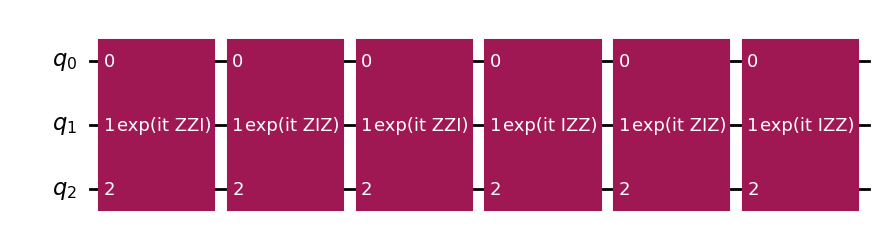

In [1715]:
# Exemple d'utilisation de la fonction
n = 3
adjence_matrix = matrices_adj[0]
t = 0.2
circuit = U_c(n, adjence_matrix, t)
circuit.decompose().draw("mpl")

## 3.4 QAOA solver

In [1716]:
from qiskit.quantum_info import Statevector

def cost_function(hamiltonian , alpha , beta):
    qubit_number = len(hamiltonian)
    psi_state_circuit = QuantumCircuit(qubit_number)

    def u_qaoa(alpha , beta):
        circuit = QuantumCircuit(qubit_number)
        for a , b in zip(alpha, beta):
            circuit = circuit.compose(U_m(qubit_number , b))
            circuit = circuit.compose(U_c(qubit_number , hamiltonian , a))
        return circuit
    
    psi_state_circuit = psi_state_circuit.compose(U_init(qubit_number))
    psi_state_circuit = psi_state_circuit.compose(u_qaoa(alpha , beta))

    psi_state = Statevector(psi_state_circuit).data


    def interaction(hamiltonian):
        non_nuls = []
        for i, ligne in enumerate(hamiltonian):
            for j, element in enumerate(ligne):
                if element != 0:
                    non_nuls.append((i, j))
        return non_nuls

    list_of_connection = interaction(hamiltonian)
    I = np.eye(2)
    Z = np.array([
        [1 ,0],
        [0  ,-1]
    ])

    # Initialiser un opérateur total vide
    ising_hamiltonian = None

    # Boucle pour créer les opérateurs et les additionner
    for (i, j) in list_of_connection:
        # Créer un vecteur de matrices I
        A = [I] * qubit_number
        # Remplacer les ième et jième éléments par Z
        A[i] = Z
        A[j] = Z
        # Initialiser l'opérateur avec la première matrice du vecteur
        operator = A[0]
        # Boucle pour effectuer les produits tensoriels
        for matrix in A[1:]:
            operator = np.kron(operator , matrix)
        # Additionner les opérateurs
        if ising_hamiltonian is None:
            ising_hamiltonian = operator
        else:
            ising_hamiltonian += operator
    
    #ising_hamiltonian = np.sum(ising_hamiltonian)
    cost = psi_state.conj().T @ ising_hamiltonian @ psi_state
    
    return cost.real , psi_state

In [1717]:
from scipy.optimize import minimize


# Fonction d'optimisation utilisant scipy.optimize.minimize
def qaoa_solver(hamiltonian, alpha_init, beta_init):
    best_cost = np.inf  # Initialiser le coût minimum avec une valeur infinie
    best_psi_state = None  # Initialiser l'état quantique optimal comme None

    # Fonction pour optimiser
    def combined_cost(params):
        nonlocal best_cost, best_psi_state

        alpha = params[:len(alpha_init)]
        beta = params[len(alpha_init):]

        cost, psi_state = cost_function(hamiltonian, alpha, beta)
        
        # Si le coût est meilleur que le coût précédent, mettre à jour
        if cost < best_cost:
            best_cost = cost
            best_psi_state = psi_state  # Garder l'état quantique correspondant au coût minimal
            
        return cost  # Retourner le coût pour minimisation

    # Initialiser les paramètres alpha et beta sous forme d'un vecteur
    initial_params = np.concatenate([alpha_init, beta_init])

    # Appeler la fonction minimize de scipy
    result = minimize(combined_cost, initial_params, method='BFGS', options={'disp': False})

    # Extraire les résultats optimisés
    optimized_params = result.x
    alpha_opt = optimized_params[:len(alpha_init)]
    beta_opt = optimized_params[len(alpha_init):]


    # Taille de l'array et nombre de bits nécessaires
    num_elements = len(best_psi_state)
    num_bits = int(np.log2(num_elements))  # Nombre de bits nécessaire pour indexer les éléments

    # Créer le dictionnaire
    probability_dict = {}

    for i in range(num_elements):
        # Convertir l'indice i en une chaîne binaire de longueur num_bits
        binary_key = format(i, f'0{num_bits}b')
        
        # Calculer le module au carré de l'amplitude
        probability = abs(best_psi_state[i])**2
        
        # Ajouter à notre dictionnaire
        probability_dict[binary_key] = probability

    

    return probability_dict  # Retourner aussi l'état quantique optimal



In [1718]:
# Paramètres initiaux
alpha_init = [3 , 5 ]#, 8 , 8]  # Valeur initiale de alpha
beta_init = [3, 5 ]#, 8 , 8]   # Valeur initiale de beta

In [1719]:
# list_result = []
# for J in matrices_adj:
#     list_result.append(qaoa_solver(J , alpha_init , beta_init))

## 3.5 Post processing

bits string: 001
Set 1: [0, 1]
Set 2: [2]

bits string: 010
Set 1: [0, 2]
Set 2: [1]

bits string: 011
Set 1: [0]
Set 2: [1, 2]

bits string: 000
Set 1: [0, 1, 2]
Set 2: []



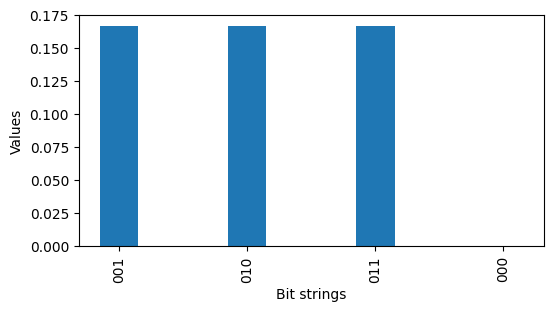

bits string: 01010
Set 1: [0, 2, 4]
Set 2: [1, 3]

bits string: 00101
Set 1: [0, 1, 3]
Set 2: [2, 4]

bits string: 00111
Set 1: [0, 1]
Set 2: [2, 3, 4]

bits string: 01101
Set 1: [0, 3]
Set 2: [1, 2, 4]

bits string: 01111
Set 1: [0]
Set 2: [1, 2, 3, 4]



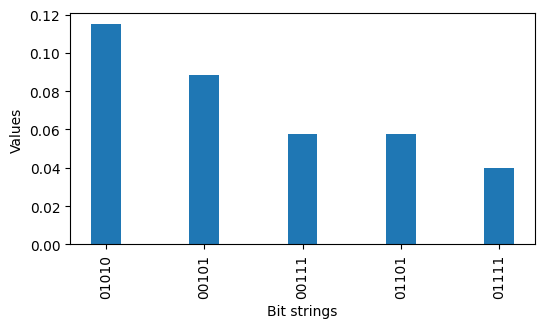

bits string: 001110
Set 1: [0, 1, 5]
Set 2: [2, 3, 4]

bits string: 011100
Set 1: [0, 4, 5]
Set 2: [1, 2, 3]

bits string: 011011
Set 1: [0, 3]
Set 2: [1, 2, 4, 5]

bits string: 011010
Set 1: [0, 3, 5]
Set 2: [1, 2, 4]

bits string: 010101
Set 1: [0, 2, 4]
Set 2: [1, 3, 5]



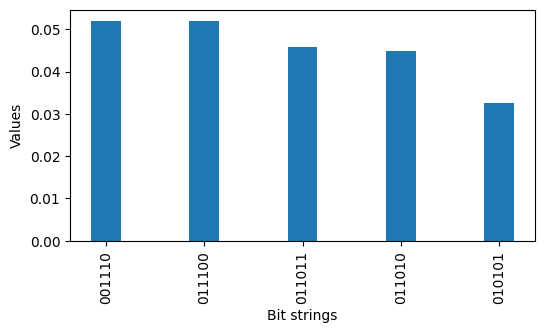

In [1720]:
def remove_complementary_bits(bit_dict):
    # Dictionary to store without redundancy
    unique_bits = {}
    
    for bits, value in bit_dict.items():
        # Generate the complement
        complement = ''.join('1' if b == '0' else '0' for b in bits)
        # If the complement is in unique_bits, do not add bits
        if complement in unique_bits:
            continue
        # Add bits to unique_bits
        unique_bits[bits] = value
    
    return unique_bits

def get_bit_positions(bit_string):
    # List of positions of 0s and 1s
    pos_zeros = [i for i, bit in enumerate(bit_string) if bit == '0']
    pos_ones = [i for i, bit in enumerate(bit_string) if bit == '1']
    return pos_zeros, pos_ones

def plot_top_5_histogram(bit_dict):
    # Remove redundant and complementary strings
    unique_bits = remove_complementary_bits(bit_dict)
    
    # Sort items by values and keep the top 5 largest
    top_10 = sorted(unique_bits.items(), key=lambda item: item[1], reverse=True)[:5]
    
    # Separate bit strings and values
    bit_strings, values = zip(*top_10)
    
    # Get positions of 0s and 1s for each bit string
    bit_positions = [get_bit_positions(bits) for bits in bit_strings]
    
    # Display the positions of 0s and 1s for each bit string
    for bit_string, (pos_zeros, pos_ones) in zip(bit_strings, bit_positions):
        print(f"bits string: {bit_string}")
        print(f"Set 1: {pos_zeros}")
        print(f"Set 2: {pos_ones}\n")
    
    # Plot the histogram
    plt.figure(figsize=(6, 3))
    plt.bar(bit_strings, values, width=0.3)
    plt.xlabel('Bit strings')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.show()


# Plot the histogram and display bit positions
for r in list_result:
    plot_top_5_histogram(r)


In [1721]:
(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])

(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])

# 4. Quantum annealer with Pulser

In [1722]:
import pulser
from pulser import DigitalAnalogDevice, Register, Pulse, Sequence
from pulser_simulation import QutipEmulator


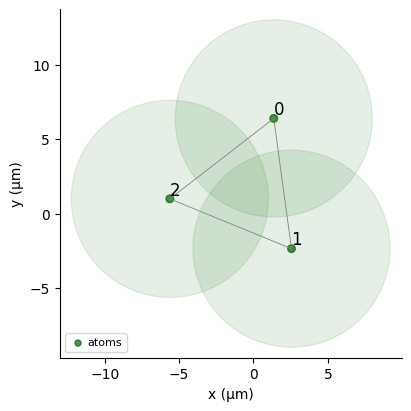

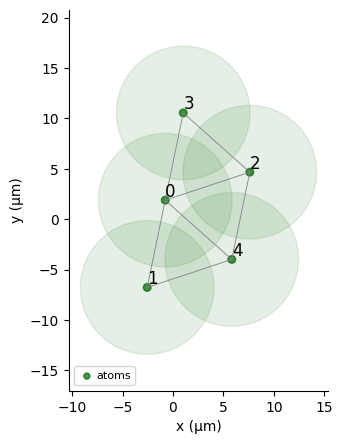

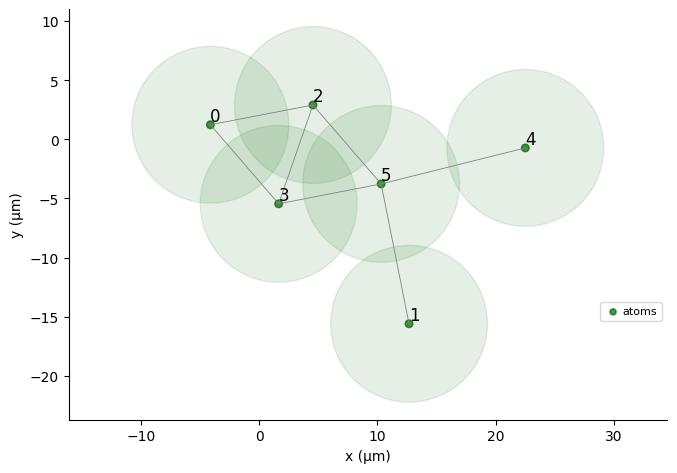

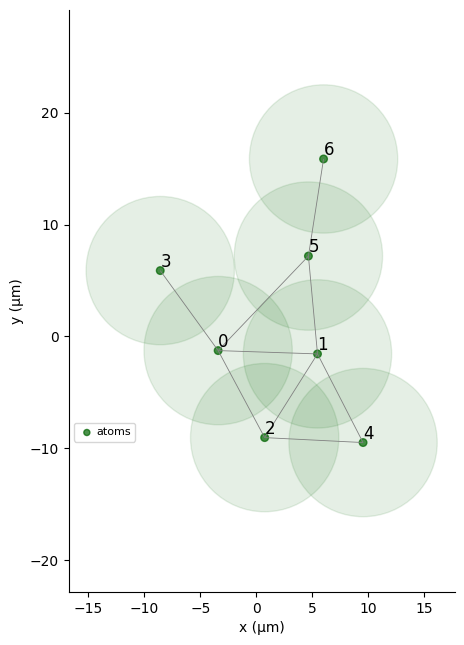

In [1723]:
from scipy.spatial.distance import pdist , squareform


def evaluate_mapping(new_coords , Q):
    """Cost function to minimize. Ideally , the pairwise distance are conserved."""
    new_coords = np.reshape(new_coords , (len(Q) , 2))
    # computing the matrix of the distance between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff/ pdist(new_coords)**6
    )
    return np.linalg.norm(new_Q - Q)

Register_list = []
for J in matrices_adj:
    costs = []
    np.random.seed(0)
    x0 = np.random.random(len(J)*2)
    res = minimize(
        evaluate_mapping,
        x0,
        args=(J,),
        method="Nelder-Mead",
        #method = "COBYLA",
        tol = 1e-6,
        options={"maxiter":2000000, "maxfev":None}
    )

    coords = np.reshape(res.x , (len(J) , 2))

    qubits = dict(enumerate(coords/1.5))
    reg = Register(qubits=qubits)
    reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1),
    draw_graph= True,
    draw_half_radius=True)
    Register_list.append(reg)
    

In [1724]:
# We choose a median value between the min and the max
Omega = 2

t_rise = 50
t_fall = t_rise
delta_0 = -18  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 10000 # time in ns, we choose a time long enough to ensure the propagation of information in the system

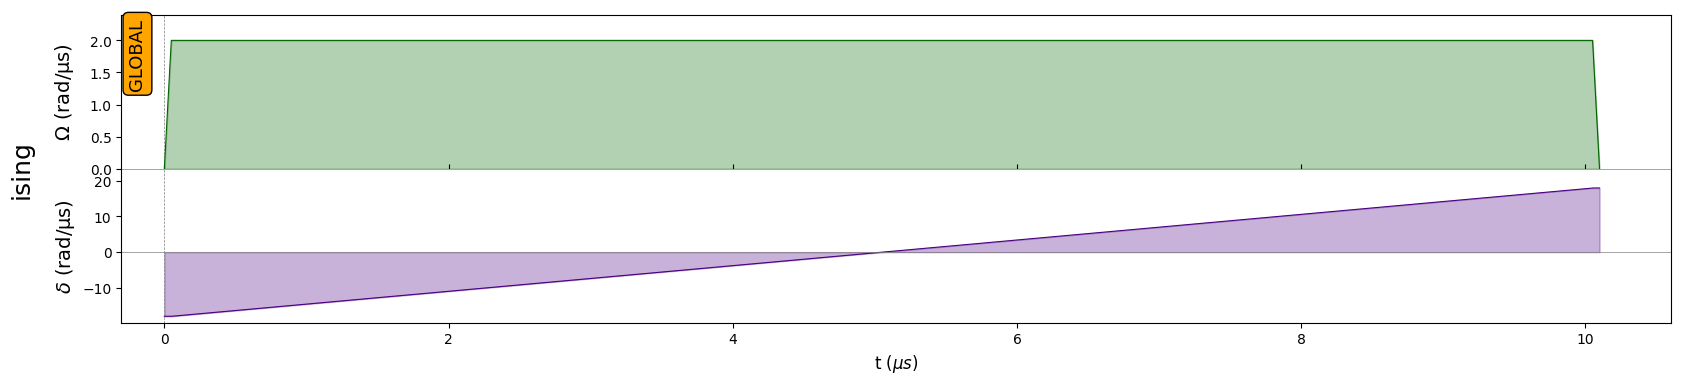

In [1725]:
from pulser.waveforms import RampWaveform
from pulser.devices import MockDevice

 # Create the rise pulse with smooth detuning
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=Omega), 
    detuning=delta_0,  # Initial detuning for the rise
    phase=0.0,
)

    # Create the sweep pulse with the filtered (smoothed) detuning profile
sweep = Pulse.ConstantAmplitude(
    amplitude=Omega,  # Use the same amplitude for the sweep
    detuning=RampWaveform(duration= T, start = delta_0 , stop = delta_f),
    phase=0.0,
)

    # Create the fall pulse with smooth detuning
fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=Omega, stop=0.0), 
    detuning=delta_f,  # Last value in the detuning profile
    phase=0.0,
)

    # Create the sequence and add the pulses to it
#seq = Sequence(Register_list[0], device=MockDevice)
seq = Sequence(Register_list[0] ,device=MockDevice)
seq.declare_channel('ising', 'rydberg_global')
seq.add(rise, 'ising', "no-delay")
seq.add(sweep, 'ising', "no-delay")
seq.add(fall, 'ising', "no-delay")
seq.draw()

In [1726]:
# #Create Pulse sequence, using default setting found
# from pulser.waveforms import InterpolatedWaveform
# adiabatic_pulse = Pulse(
#     InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
#     InterpolatedWaveform(T, [delta_0, 0, delta_f]),
#     0,
# )
# seq = Sequence(Register_list[0], DigitalAnalogDevice)
# seq.declare_channel("ising", "rydberg_global")
# seq.add(adiabatic_pulse, "ising")
# seq.draw()

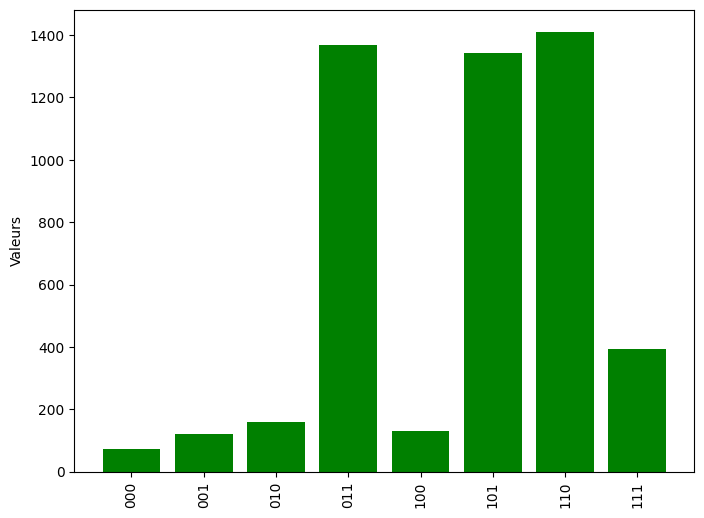

In [1727]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples= 5000)

# Création de l'histogramme
plt.figure(figsize=(8, 6))
plt.bar(list(count_dict.keys()), list(count_dict.values()), color='green')
plt.xticks(rotation = "vertical")
plt.ylabel('Valeurs')
plt.show()

In [1728]:
[[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]]
[[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]]
[[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]]
[[9, [2, 4, 5, 6], [0, 1, 3]]]

[[9, [2, 4, 5, 6], [0, 1, 3]]]

In [1729]:
afficher toute les soluttion et marquer parmi les resultats ceux qui ont été proposé par la méthode classique
ensuite convertir la serie de bit en une partision de de graphe claire

SyntaxError: invalid syntax (1242555464.py, line 1)

# Conclusion